### Chemical Space Visualization using PCA and t-SNE
###  Database: Bioactivity data MAP Kinase ERK2 from ChEMBL

### Import Libraries and read file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from molvs import standardize_smiles

from sklearn.model_selection import train_test_split

In [2]:
x=pd.read_csv('erk2.csv')
x.head(2)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL440356,NaN,0.0,243.06,0,1.09,2,O=C1CCNC(=O)c2[nH]c(Br)cc21,IC50,'=',...,MAP kinase ERK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1135814,1.0,Scientific Literature,J. Med. Chem.,2002.0,None,NaN
1,CHEMBL260417,NaN,0.0,373.21,0,3.44,SB-725317,O=C(Nc1n[nH]c2nc(-c3ccc(O)cc3)c(Br)cc12)C1CC1,Inhibition,'=',...,MAP kinase ERK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1961873,16.0,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN


In [3]:
x.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

### Data preprocessing

In [4]:
x1=x[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Value','Standard Units']]
print(x1.shape)
x1.head(2)

(23306, 5)


,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
0,CHEMBL440356,O=C1CCNC(=O)c2[nH]c(Br)cc21,IC50,539.00,nM
1,CHEMBL260417,O=C(Nc1n[nH]c2nc(-c3ccc(O)cc3)c(Br)cc12)C1CC1,Inhibition,5.75,%


In [5]:
x1=x1[x1['Standard Units'].str.contains('nM', na=False)]
x1.drop_duplicates(inplace=True)
print(x1.shape)
x1.head(2)

(18810, 5)


,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
0,CHEMBL440356,O=C1CCNC(=O)c2[nH]c(Br)cc21,IC50,539.0,nM
2,CHEMBL213451,CCNc1nnc2ccc(-c3ocnc3-c3ccc(F)cc3)cn12,IC50,10000.0,nM


In [6]:
x1.isnull().apply(pd.value_counts)

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
False,18810.0,18762,18810.0,18806,18810.0
True,NaN,48,NaN,4,NaN


In [7]:
x1.dropna(inplace=True)
x1.shape

(18758, 5)

In [8]:
x1['New Std_value']=x1.groupby('Molecule ChEMBL ID')['Standard Value'].transform('mean')
x1=x1.drop_duplicates('Molecule ChEMBL ID', keep='first')
x1=x1.sort_values('New Std_value', ascending=True).reset_index(drop=True)
x1=x1.drop(['Standard Type', 'Standard Value', 'Standard Units'], axis=1)
print(x1.shape)
x1.head(3)

(17739, 3)


,Molecule ChEMBL ID,Smiles,New Std_value
0,CHEMBL4868141,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...,-29600.00000
1,CHEMBL4115001,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...,0.00431
2,CHEMBL4111166,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...,0.00500


In [9]:
x1['Smiles'].duplicated().sum()

0

### Seggregate data into Actives (Label = 1)and Inactives (Label = 0)

In [10]:
x1['Label']=x1['New Std_value'].apply(lambda x: 1 if x <=10000 else 0)
x1.head()

,Molecule ChEMBL ID,Smiles,New Std_value,Label
0,CHEMBL4868141,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...,-29600.00000,1
1,CHEMBL4115001,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...,0.00431,1
2,CHEMBL4111166,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...,0.00500,1
3,CHEMBL3904235,Nc1ncc([C@H]2CC[C@H](O)[C@@H](O)C2)nc1-c1ccc(C...,0.00550,1
4,CHEMBL3980387,NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc2N)cc1F...,0.00612,1


In [11]:
x1['Label'].value_counts()

0    10534
1     7205
Name: Label, dtype: int64

### Convert Smiles into Fingerprints

In [12]:
std_smiles=[standardize_smiles(smi) for smi in x1['Smiles'] if smi is not None]

In [13]:
std_smi=pd.DataFrame(std_smiles, columns=['Std_Smiles'])
x2=pd.concat([x1[['Molecule ChEMBL ID', 'New Std_value', 'Label']],std_smi],axis=1)
x2.drop_duplicates('Std_Smiles', keep='first', inplace=True)
print(x2.shape)
x2.head()

(17738, 4)


,Molecule ChEMBL ID,New Std_value,Label,Std_Smiles
0,CHEMBL4868141,-29600.00000,1,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...
1,CHEMBL4115001,0.00431,1,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...
2,CHEMBL4111166,0.00500,1,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...
3,CHEMBL3904235,0.00550,1,Nc1ncc([C@H]2CC[C@H](O)[C@@H](O)C2)nc1-c1ccc(C...
4,CHEMBL3980387,0.00612,1,NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc2N)cc1F...


In [14]:
x2[['Std_Smiles','Label']].to_csv('erk2_labelled.smi', sep='\t', index=None, header=None)

In [15]:
supplier=Chem.SmilesMolSupplier('erk2_labelled.smi', delimiter='\t', titleLine=None)

In [16]:
morgan_fp=[AllChem.GetMorganFingerprintAsBitVect(mol,2,1024) for mol in supplier]

In [17]:
IDs=[mol.GetProp('_Name') for mol in supplier]

In [18]:
fps=np.asarray(morgan_fp, dtype=np.int32)
labels=np.asarray(IDs, dtype=np.int32).reshape(-1,1)

In [19]:
combined=np.concatenate([fps,labels], axis=1)
np.savetxt('erk2_morganfp_labelled.csv', combined, delimiter=',')

In [20]:
erk2_csv=pd.read_csv('erk2_morganfp_labelled.csv', sep=',', header=None)
print(erk2_csv.shape)
erk2_csv.head()

(17738, 1025)


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


### Scale features/Fingerprints

In [21]:
X=erk2_csv.iloc[:,0:1024]
y=erk2_csv.iloc[:,1023:1024]
print('Features Dimension:',X.shape)
print('Labels Dimension:',y.shape)

Features Dimension: (17738, 1024)
Labels Dimension: (17738, 1)


In [22]:
from sklearn.preprocessing import StandardScaler

X_scaled=StandardScaler().fit_transform(X)
X_scaled

array([[-0.1051566 , -0.53689499,  4.49641005, ..., -0.14815802,
        -0.11232237, -0.09419507],
       [-0.1051566 ,  1.86256162, -0.22239965, ..., -0.14815802,
         8.90294577, -0.09419507],
       [-0.1051566 ,  1.86256162, -0.22239965, ..., -0.14815802,
         8.90294577, -0.09419507],
       ...,
       [-0.1051566 , -0.53689499,  4.49641005, ..., -0.14815802,
        -0.11232237, -0.09419507],
       [-0.1051566 , -0.53689499, -0.22239965, ..., -0.14815802,
        -0.11232237, -0.09419507],
       [-0.1051566 , -0.53689499, -0.22239965, ..., -0.14815802,
        -0.11232237, -0.09419507]])

### Perform PCA on Scaled Fingerprints

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca2=PCA(n_components=2)
reduced=pca2.fit_transform(X_scaled)

In [25]:
reduced_df=pd.DataFrame(reduced, columns=['PC1','PC2'])
reduced_df['Label']=erk2_csv[1024]
reduced_df.head()

,PC1,PC2,Label
0,0.894951,5.061109,1.0
1,6.429508,20.823927,1.0
2,5.802275,20.313333,1.0
3,6.429508,20.823927,1.0
4,5.787911,19.801356,1.0


### Plot of the two Principal Components

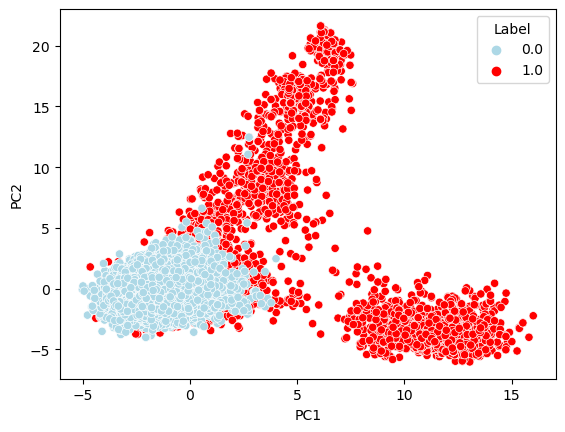

In [26]:
ax = sns.scatterplot(data=reduced_df,x="PC1",y="PC2",hue="Label",palette={0:'lightblue',1:'red'})

### Cummulative variance from the two components

In [27]:
cum_var=np.sum(pca2.explained_variance_ratio_)
cum_var

0.02641700106355629

The first two components explain approximately 3% of the variance in the data which is not enough. Let's perform PCA on all components.

### Perform PCA on all components

In [28]:
pca=PCA(n_components=1024)
pca.fit_transform(X_scaled)

array([[ 8.96139112e-01,  5.06716320e+00, -1.08199412e+00, ...,
         6.18890529e-01, -5.20487265e-01,  1.00698456e-01],
       [ 6.42889766e+00,  2.08288688e+01, -9.89203489e+00, ...,
        -7.75565729e-02,  9.20324684e-03, -8.85238250e-02],
       [ 5.80155715e+00,  2.03193205e+01, -1.02814278e+01, ...,
         3.40824734e-02, -7.60612057e-02, -9.16265743e-02],
       ...,
       [-9.34200950e-01,  3.56668072e-01,  1.01447240e+00, ...,
         5.92234671e-02,  5.57693471e-01,  3.16560732e-01],
       [-5.91558392e-01,  2.36849669e+00,  3.23658653e+00, ...,
        -3.28053678e-01,  1.61066621e-01,  3.07921718e-01],
       [-6.46576975e-01,  9.06028555e-01,  5.52565955e-01, ...,
        -2.93991321e-01, -1.15865398e-01,  4.08237796e-02]])

In [29]:
print(pca.explained_variance_ratio_)

[1.54366011e-02 1.09804262e-02 7.67662915e-03 ... 7.53385300e-05
 7.49928576e-05 7.20438698e-05]


In [30]:
df=pd.DataFrame(pca.explained_variance_ratio_)
df[0].max()

0.015436601063721299

### Plot of # Components Vs Variance explained

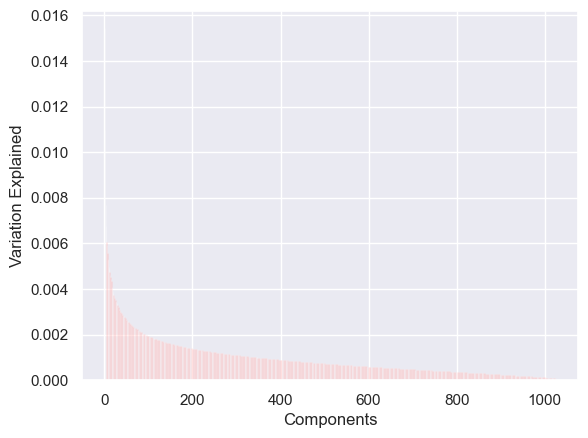

In [31]:
sns.set(font_scale=1.0)
plt.bar(list(range(1,1025)),pca.explained_variance_ratio_, alpha=0.2, color='red')
plt.ylabel('Variation Explained')
plt.xlabel('Components')
plt.show()

### Plot of # Components Vs Cummulative variance explained

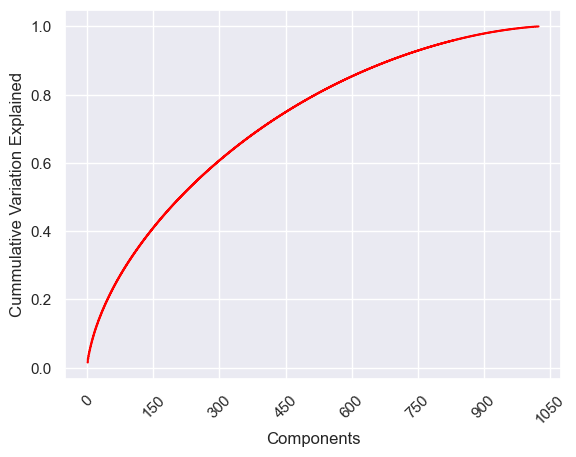

In [32]:
plt.step(list(range(1,1025)),np.cumsum(pca.explained_variance_ratio_), where='mid', color='red')
plt.ylabel('Cummulative Variation Explained')
plt.xlabel('Components')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(150))
plt.xticks(rotation=45)
plt.show()

### Apply Kaiser's rule - keep all components with eigen value > 1

In [33]:
eigenValues=pd.DataFrame(pca.explained_variance_, columns=['Eigen_values'])
eigenValues.head()

,Eigen_values
0,15.807971
1,11.244590
2,7.861311
3,6.944495
4,6.226267


In [34]:
eigenValues[eigenValues['Eigen_values']>1].count()

Eigen_values    356
dtype: int64

Based on the cummulative variance plot and Kaiser's rule, nearly 350 components account for around 70% of the variance.

### Apply t-SNE. Use PCA to reduce the dataset to 350 components.

In [35]:
pca=PCA(n_components=350)
reduced_data=pca.fit_transform(X_scaled)

In [36]:
from sklearn.manifold import TSNE
tsne_data=TSNE(n_components=2).fit_transform(reduced_data)

C:\Users\ramya_cq41ur2\anaconda3\envs\uresearcher\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\ramya_cq41ur2\anaconda3\envs\uresearcher\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [37]:
tsne_df=pd.DataFrame(tsne_data, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Label']=erk2_csv[1024]
tsne_df.head()

,TSNE_1,TSNE_2,Label
0,-80.835487,15.513230,1.0
1,-67.987610,45.560890,1.0
2,-67.174370,45.263302,1.0
3,-67.987610,45.560890,1.0
4,-69.750931,44.620613,1.0


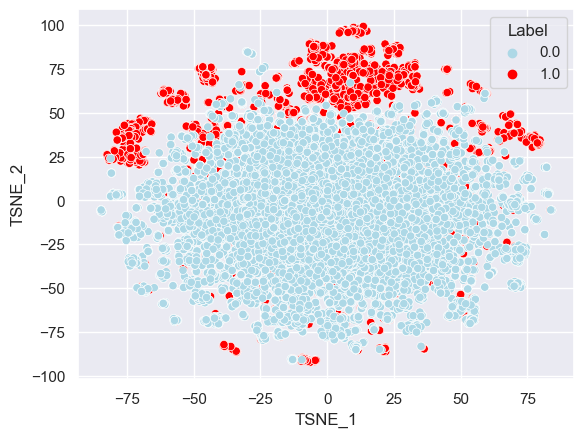

In [38]:
ax = sns.scatterplot(data=tsne_df,x="TSNE_1",y="TSNE_2",hue="Label",palette={0:'lightblue',1:'red'})

### t-SNE on reduced dataset PCA of 50 components

In [39]:
pca50=PCA(n_components=50)
reduced_data2=pca50.fit_transform(X_scaled)

In [40]:
tsne_data2=TSNE(n_components=2).fit_transform(reduced_data2)

C:\Users\ramya_cq41ur2\anaconda3\envs\uresearcher\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\ramya_cq41ur2\anaconda3\envs\uresearcher\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [41]:
tsne_df2=pd.DataFrame(tsne_data2, columns=['TSNE_1', 'TSNE_2'])
tsne_df2['Label']=erk2_csv[1024]
tsne_df2.head()

,TSNE_1,TSNE_2,Label
0,43.536587,6.770082,1.0
1,86.337845,3.215057,1.0
2,86.567574,3.862156,1.0
3,86.337883,3.215066,1.0
4,85.944061,0.108872,1.0


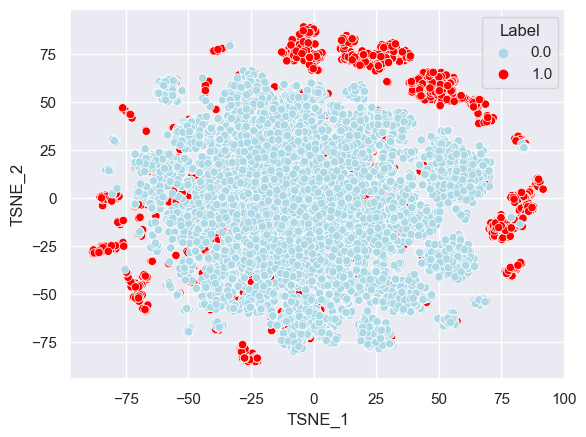

In [42]:
ax = sns.scatterplot(data=tsne_df2,x="TSNE_1",y="TSNE_2",hue="Label",palette={0:'lightblue',1:'red'})

In [43]:
output_tsne_df = pd.concat([x2["Molecule ChEMBL ID"],reduced_df[["PC1","PC2"]],tsne_df[["TSNE_1","TSNE_2"]]],axis=1)
output_tsne_df.head()

,Molecule ChEMBL ID,PC1,PC2,TSNE_1,TSNE_2
0,CHEMBL4868141,0.894951,5.061109,-80.835487,15.513230
1,CHEMBL4115001,6.429508,20.823927,-67.987610,45.560890
2,CHEMBL4111166,5.802275,20.313333,-67.174370,45.263302
3,CHEMBL3904235,6.429508,20.823927,-67.987610,45.560890
4,CHEMBL3980387,5.787911,19.801356,-69.750931,44.620613


In [44]:
output_tsne_df.to_csv('output_tsne.csv', index=None)